In [1]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)
from collections import Counter
import operator
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups

['talk.religion.misc', 'talk.politics.misc', 'alt.atheism', 'talk.politics.guns', 'talk.politics.mideast', 'comp.sys.mac.hardware', 'comp.graphics', 'misc.forsale', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'sci.electronics', 'sci.space', 'comp.windows.x', 'rec.autos', 'sci.med', 'sci.crypt', 'rec.sport.baseball', 'rec.motorcycles', 'soc.religion.christian', 'rec.sport.hockey']
[377, 465, 480, 546, 564, 578, 584, 585, 590, 591, 591, 593, 593, 594, 594, 595, 597, 598, 599, 600]


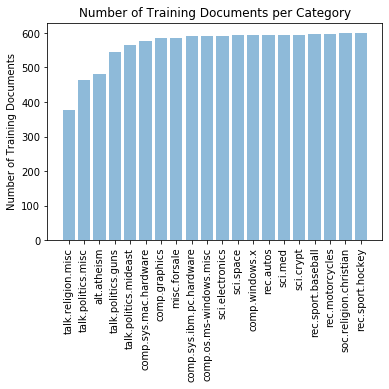

In [231]:
#Question 1
#Histogram containing the total number of training documents per category.

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
targets = newsgroups_train.target
target_names = newsgroups_train.target_names
target_frequency = Counter(targets)
target_frequency = sorted(target_frequency.items(), key=operator.itemgetter(1))
X = []
Y = []

for e in target_frequency:
    X.append(target_names[e[0]])
    Y.append(e[1])
print(X)
print(Y)

plt.bar(X, Y, align='center', alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of Training Documents")
plt.title("Number of Training Documents per Category")

plt.show()


In [28]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(newsgroups_train.data[:2])
# print(vectorizer.get_feature_names(), X)

['11', '15', '1qvfo9innc3s', '60s', '70s', '800', 'acceleration', 'adapters', 'add', 'addition', 'answered', 'article', 'attained', 'base', 'body', 'brave', 'bricklin', 'brief', 'brought', 'bumper', 'called', 'car', 'cards', 'carson', 'clock', 'college', 'cpu', 'day', 'days', 'detailing', 'disk', 'door', 'doors', 'early', 'edu', 'engine', 'enlighten', 'especially', 'experiences', 'fair', 'final', 'floppies', 'floppy', 'functionality', 'funky', 'guy', 'guykuo', 'haven', 'heat', 'history', 'host', 'hour', 'il', 'info', 'keywords', 'know', 'knowledge', 'kuo', 'late', 'lerxst', 'lines', 'looked', 'looking', 'mail', 'maryland', 'message', 'model', 'neighborhood', 'network', 'nntp', 'number', 'organization', 'oscillator', 'park', 'poll', 'posting', 'procedure', 'production', 'rac3', 'rated', 'really', 'reports', 'requested', 'rest', 'saw', 'send', 'separate', 'shared', 'shelley', 'si', 'sinks', 'small', 'souls', 'specs', 'speed', 'sports', 'subject', 'summarizing', 'summary', 'tellme', 'than

In [98]:
import re
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words('english'))

def no_num_tokenizer(document):
    unlemmatized_words = [word for word in re.split('[^a-zA-Z]+', document) if len(word)>2]
    words = [lemmatizer.lemmatize(word) for word in unlemmatized_words if word not in stop_words]
    return words

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\meet1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meet1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This is a really bad lemmatizer. It does nothing except for changing plurals to their singular form

In [165]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer

vectorizer = CountVectorizer(stop_words=None, tokenizer=no_num_tokenizer, min_df=3)
tf_train = vectorizer.fit_transform(newsgroups_train.data)

tf_test = vectorizer.fit_transform(newsgroups_test.data)

In [206]:
df_train = (tf_train>0).sum(axis=0).flatten()
idf_train = np.log(tf_train.shape[0]/df_train)+1

# df_test = (tf_test>0).sum(axis=0).flatten()
# idf_test = np.log(tf_train.shape[0]/df_train)+1
# https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest

df_test = (tf_test>0).sum(axis=0).flatten()
idf_test = np.log(tf_test.shape[0]/df_test)+1

In [214]:
tf_idf_train = tf_train.copy().astype(float)

for i in range(tf_train.shape[1]):
    tf_idf_train[:,i] = tf_train[:,i] * idf_train[0,i]

print(tf_idf_train.shape)

In [ ]:
tf_idf_test = tf_test.copy().astype(float)

for i in range(tf_test.shape[1]):
    tf_idf_test[:,i] = tf_test[:,i] * idf_test[0,i]

print(tf_idf_test.shape)